In [1]:
from pathlib import Path
import sys
project_dir = Path("__file__").resolve().parents[2]
sys.path.insert(0, '{}/temporal_granularity/'.format(project_dir))

import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import pairwise_distances_argmin_min

from sklearn.cluster import KMeans

pd.set_option('display.max_rows', 200)





In [2]:
pv_original = pd.read_csv(
        '{}/data/processed/resources/pv_processed.csv'.format(project_dir))
pv_original['type'] = 'solar'
onshore_original = pd.read_csv(
        '{}/data/processed/resources/onshore_processed.csv'.format(project_dir))
onshore_original['type'] = 'onshore'
offshore_original = pd.read_csv(
        '{}/data/processed/resources/offshore_processed.csv'.format(project_dir))
offshore_original['type'] = 'offshore'
load_original = pd.read_csv(
        '{}/data/processed/demand/load_NG/load_processed.csv'.format(project_dir))
load_original['type'] = 'load'

total_data = [pv_original, onshore_original, offshore_original, load_original]

In [3]:
data = pd.concat(total_data)
data.head()

,Unnamed: 0,datetime,capacity_factor,type
0,0,1980-01-01 00:00:00,0.0,solar
1,1,1980-01-01 01:00:00,0.0,solar
2,2,1980-01-01 02:00:00,0.0,solar
3,3,1980-01-01 03:00:00,0.0,solar
4,4,1980-01-01 04:00:00,0.0,solar


In [4]:
data = pd.concat(total_data)


data = data.drop('Unnamed: 0', axis=1)

data.set_index('datetime', inplace=True)
data.index = pd.to_datetime(data.index)

data['date'] = data.index.date
data['hour'] = data.index.hour
data['year'] = data.index.year

# Scaling Load

In [5]:
data[data.type=='load'].head()

,capacity_factor,type,date,hour,year
datetime,,,,,
2005-04-01 00:00:00,33321.0,load,2005-04-01,0,2005
2005-04-01 01:00:00,32893.5,load,2005-04-01,1,2005
2005-04-01 02:00:00,34647.0,load,2005-04-01,2,2005
2005-04-01 03:00:00,34135.0,load,2005-04-01,3,2005
2005-04-01 04:00:00,32699.5,load,2005-04-01,4,2005


In [6]:
data.loc[data.type=='load', 'capacity_factor'] = data[data.type=='load'].groupby('year')['capacity_factor'].apply(lambda x: (x-x.min())/(x.max()-x.min())).values

data[data.type=='load'].head()


,capacity_factor,type,date,hour,year
datetime,,,,,
2005-04-01 00:00:00,0.310448,load,2005-04-01,0,2005
2005-04-01 01:00:00,0.299035,load,2005-04-01,1,2005
2005-04-01 02:00:00,0.345850,load,2005-04-01,2,2005
2005-04-01 03:00:00,0.332181,load,2005-04-01,3,2005
2005-04-01 04:00:00,0.293855,load,2005-04-01,4,2005


In [7]:
data = data.pivot_table(index='date', columns=['hour','type'], values='capacity_factor')


data = data.dropna()
data
k_means = KMeans(n_clusters=8)
k_means.fit(data)

y_kmeans = k_means.predict(data)

y_kmeans_df = pd.DataFrame(y_kmeans)
y_kmeans_df = y_kmeans_df.rename(columns={y_kmeans_df.columns[0]: 'cluster'})


y_kmeans_df.groupby("cluster").agg('count')



""
cluster
0
1
2
3
4
5
6
7


In [8]:
count = y_kmeans_df.reset_index().groupby("cluster").count()
to_divide = np.sum(count.iloc[:,0])/365
count.iloc[:,0] = count.iloc[:,0]/to_divide
count.iloc[:,0] = np.ceil(count.iloc[:,0])
count = count.reset_index()
count = count.rename(columns={"index":"number"})
to_remove = 365-np.sum(count.number)
to_remove
count.number.iloc[-1] = count.number.iloc[-1]+to_remove

/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
data_w_kmeans = data.copy()
# data_w_kmeans['cluster'] = y_kmeans

data_w_kmeans

closest_data_points, _ = pairwise_distances_argmin_min(k_means.cluster_centers_, data)
eight_medoids_wide = data.iloc[closest_data_points,:]
eight_medoids_wide['number'] = count.number.values

eight_medoids_wide

/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


hour               0                                1                         \
type            load offshore onshore solar      load offshore onshore solar   
date                                                                           
2012-07-26  0.215030   0.1383  0.0900   0.0  0.158975   0.1357  0.0887   0.0   
2015-11-25  0.317039   0.6151  0.4233   0.0  0.300081   0.6252  0.4243   0.0   
2012-11-07  0.305982   0.5867  0.4794   0.0  0.312104   0.5694  0.4877   0.0   
2008-11-04  0.343182   0.2116  0.1301   0.0  0.336312   0.2017  0.1302   0.0   
2012-02-18  0.347814   0.6902  0.7050   0.0  0.342861   0.7144  0.7082   0.0   
2015-08-27  0.180977   0.5847  0.3578   0.0  0.118152   0.5824  0.3766   0.0   
2011-11-09  0.302910   0.2965  0.2588   0.0  0.286395   0.2999  0.2616   0.0   
2010-08-12  0.170267   0.3670  0.2303   0.0  0.114677   0.3748  0.2319   0.0   

hour               2           ...    21        22                         \
type            load offshore  ... solar      load offshore onshore solar   
date                           ...                                          
2012-07-26  0.136003   0.1362  ...   0.0  0.416523   0.1331  0.1163   0.0   
2015-11-25  0.265768   0.6201  ...   0.0  0.539591   0.4289  0.2668   0.0   
2012-11-07  0.278622   0.5427  ...   0.0  0.483871   0.7168  0.6170   0.0   
2008-11-04  0.308192   0.1997  ...   0.0  0.532123   0.2092  0.1218   0.0   
2012-02-18  0.296202   0.7362  ...   0.0  0.447075   0.7438  0.5443   0.0   
2015-08-27  0.094721   0.5694  ...   0.0  0.399605   0.4547  0.2717   0.0   
2011-11-09  0.248614   0.3046  ...   0.0  0.503679   0.4516  0.4050   0.0   
2010-08-12  0.095393   0.3728  ...   0.0  0.366903   0.3966  0.2763   0.0   

hour              23                        number  
type            load offshore onshore solar         
date                                                
2012-07-26  0.317950   0.1151  0.1132   0.0   82.0  
2015-11-25  0.413107   0.3820  0.2623   0.0   33.0  
2012-11-07  0.369217   0.7328  0.6334   0.0   26.0  
2008-11-04  0.415143   0.2064  0.1051   0.0   53.0  
2012-02-18  0.380428   0.7537  0.5163   0.0   31.0  
2015-08-27  0.286637   0.4240  0.2705   0.0   43.0  
2011-11-09  0.380839   0.4112  0.3701   0.0   32.0  
2010-08-12  0.271218   0.4010  0.2830   0.0   65.0  

[8 rows x 97 columns]

In [10]:
eight_medoids_wide = eight_medoids_wide.reset_index()
eight_medoids_wide
eight_medoids = eight_medoids_wide.melt(id_vars=["date","number"])
eight_medoids = eight_medoids.sort_values(['date', 'type','hour'])

eight_medoids = eight_medoids.groupby("type", as_index=False).apply(lambda x: x.reset_index())
eight_medoids = eight_medoids.reset_index()
eight_medoids

,level_0,level_1,index,date,number,hour,type,value
0,0,0,3,2008-11-04,53.0,0,load,0.343182
1,0,1,35,2008-11-04,53.0,1,load,0.336312
2,0,2,67,2008-11-04,53.0,2,load,0.308192
3,0,3,99,2008-11-04,53.0,3,load,0.286708
4,0,4,131,2008-11-04,53.0,4,load,0.247604
5,0,5,163,2008-11-04,53.0,5,load,0.245180
6,0,6,195,2008-11-04,53.0,6,load,0.327890
7,0,7,227,2008-11-04,53.0,7,load,0.514822
8,0,8,259,2008-11-04,53.0,8,load,0.620997
9,0,9,291,2008-11-04,53.0,9,load,0.651374


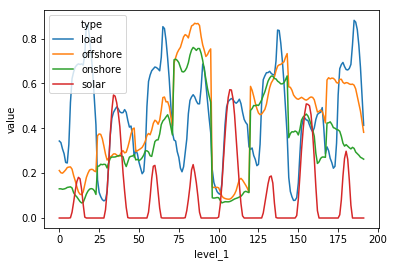

In [11]:
sns.lineplot(data=eight_medoids, x='level_1', y='value', hue='type')


In [12]:
eight_medoids = eight_medoids.rename(columns={'type':'data_type', 'number':'cluster', 'value':'capacity_factor'})

In [13]:
eight_medoids[(eight_medoids.data_type=="load") & (eight_medoids.cluster==62)]

,level_0,level_1,index,date,cluster,hour,data_type,capacity_factor


In [14]:
np.unique(eight_medoids.cluster)

array([26., 31., 32., 33., 43., 53., 65., 82.])

In [15]:
eight_medoids[(eight_medoids.data_type=="load") & (eight_medoids.cluster==59)].sort_values(by='capacity_factor', ascending=False)['cluster'].cumsum().index



Int64Index([], dtype='int64')

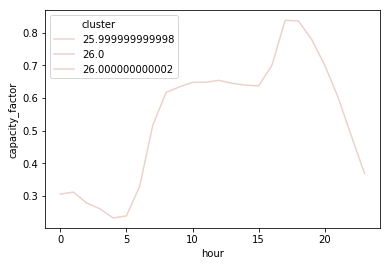

In [16]:
sns.lineplot(data=eight_medoids[(eight_medoids.data_type=="load") & (eight_medoids.cluster==np.unique(eight_medoids.cluster)[0])], x='hour', y='capacity_factor', hue='cluster')



In [17]:
eight_medoids = eight_medoids.drop(columns=['level_0', 'index']).rename(index=str, columns={'level_1':'index'})
eight_medoids.to_csv('/Users/b1017579/Documents/PhD/Projects/10. ELECSIM/elecsim/data/processed/multi_day_data/4_medoids.csv')


In [18]:
def print_dat(x):
    print(x.iloc[0,2])

eight_medoids[eight_medoids.data_type == "load"].groupby('cluster').apply(lambda x: print_dat(x))

26.0
26.0
31.0
32.0
33.0
43.0
53.0
65.0
82.0


""


In [19]:
pd.unique(eight_medoids.cluster)

array([53., 65., 32., 31., 82., 26., 43., 33.])

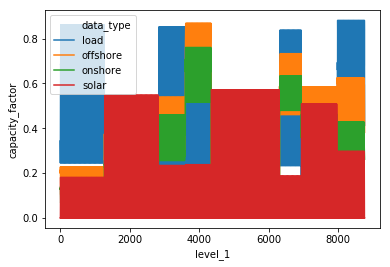

In [20]:
def reindex_days(dat, grouped_vars):
    dat = pd.concat([dat]*int(grouped_vars[1]), ignore_index=True)
    dat.reset_index(inplace=True)
    return dat

eight_medoids_grouped = eight_medoids.groupby(['data_type','cluster'], sort=False).apply(lambda x: reindex_days(x, x.name))
eight_medoids_grouped = eight_medoids_grouped.drop(columns=['level_0', 'cluster', 'data_type'])
final = eight_medoids_grouped.reset_index().groupby('data_type', sort=False).apply(lambda x: x.reset_index())
final = final.drop(columns='data_type').reset_index()
sns.lineplot(data = final, x='level_1', y='capacity_factor', hue='data_type')

In [21]:
final = final.rename(columns={'level_1':"demand_hour"})[['demand_hour','data_type','capacity_factor']]
final['demand_hour'] = final['demand_hour'] + 1


In [22]:
final

,demand_hour,data_type,capacity_factor
0,1,load,0.343182
1,2,load,0.336312
2,3,load,0.308192
3,4,load,0.286708
4,5,load,0.247604
5,6,load,0.245180
6,7,load,0.327890
7,8,load,0.514822
8,9,load,0.620997
9,10,load,0.651374


In [23]:
final[(final.data_type=="load") &(final.demand_hour >= 8400)].capacity_factor.head(1)


8399    0.413107
Name: capacity_factor, dtype: float64

In [24]:
final.to_csv('/Users/b1017579/Documents/PhD/Projects/10. ELECSIM/elecsim/data/processed/multi_day_data/4_medoids_scaled.csv')
